# Forecasting forced displacement



In [1]:
import pandas as pd
from time import time
import os
import json
import pickle
import numpy as np 
from time import time

import seaborn as sns
import matplotlib.pyplot as plt

# Data transforms

<TBC>

In [2]:
start_time = time()
with open("../configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join("..", config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources']]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))


# Now arrange data in long form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)

print("Long form of size  : {} (rows) {} (columns)".format(*data.shape))

Sources            : 16
Shape              : 648284 (rows) 9 (columns)
Geographies        : 505
Indicators         : 122
Temporal coverage  : 1789.0 -> 2019.0
Null values        : 1410

Loaded data in 0.94 sec.
Long form of size  : 34122 (rows) 123 (columns)


In [3]:
# Define the subset to work with

countries = ['AFG', 'MMR']

# Features
idx = ['Country Code', 'year']
mm = ['ETH.TO.{}'.format(i) for i in ['DNK', 'GBR', 'ITA', 'SAU', 'SWE', 'ZAF']]
endo = ['UNHCR.OUT.AS', 'UNHCR.OUT.IDP', 'UNHCR.OUT.OOC', 
        'UNHCR.OUT.REF', 'UNHCR.OUT.RET', 'UNHCR.OUT.RETIDP']
# missing entirely
emdat = ['EMDAT.CPX.OCCURRENCE','EMDAT.CPX.TOTAL.DEATHS','EMDAT.CPX.TOTAL.AFFECTED','EMDAT.CPX.AFFECTED']
target = ['IDP', 'UNHCR.EDP']
features = list(set(data.columns.tolist()) - set(idx + mm + endo + target + emdat))

# filter
c1 = data['Country Code'].isin(countries)
c2 = data.year >= 1950

df = data.loc[c1 & c2, idx + features + target]
print("Filtered data has {} rows, {} columns.".format(*df.shape))

Filtered data has 140 rows, 107 columns.


In [4]:
# data quality and coverage

for c in countries:
    idx = df['Country Code'] == c
    print("\n" + c + " ({} obs)".format(sum(idx)))
    print("Time period: {} -> {}".format(df.loc[idx, 'year'].min(), df[idx].year.max()))
    datapoints = df[idx].notna().sum() # * 100 / len(df[idx])
    print(datapoints.sort_values(ascending=False)[:])


AFG (70 obs)
Time period: 1950.0 -> 2019.0
Indicator Code
Country Code              70
year                      70
VDEM.FRD.POL.KILL         69
VDEM.EXL.SOC.GRP          69
SP.PV.ETH.VIOL            69
                          ..
EMDAT.TEC.HOMELESS         1
EMDAT.TEC.AFFECTED         1
EMDAT.TEC.TOTAL.DAMAGE     0
SI.POV.GINI                0
ER.GDP.FWTL.M3.KD          0
Length: 107, dtype: int64

MMR (70 obs)
Time period: 1950.0 -> 2019.0
Indicator Code
Country Code        70
year                70
SP.PV.ETH.VIOL      69
SP.PV.CIV.VIOL      69
SP.PV.ETH.WAR       69
                    ..
VDEM.FRD.REL         0
ACLED.COUNT          0
WFP.PRC.WHT          0
VDEM.EXL.SOC.GRP     0
ACLED.FATALITIES     0
Length: 107, dtype: int64


/Users/rahul/anaconda3/envs/mm4sight/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7847: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(Z) > precision


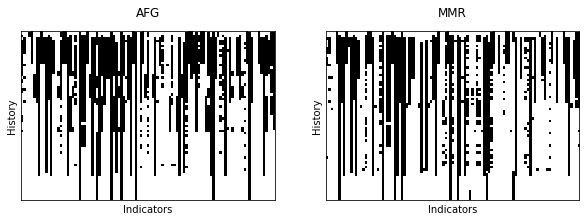

In [5]:

fig, ax = plt.subplots(1, len(countries), 
                       figsize=(10, 4), 
                       sharex='col', sharey='row')
for i, c in enumerate(countries):
    
    idx = df['Country Code'] == c
    ax[i].spy(df.loc[idx, features + target].values, origin='lower')
    ax[i].set_xlabel("Indicators")
    ax[i].set_ylabel("History")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(c)
plt.savefig("img/coverage.png", dpi=200, bbox_inches='tight')

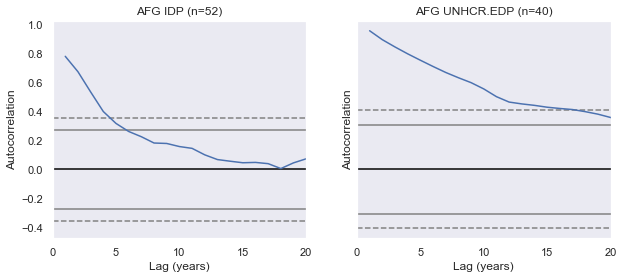

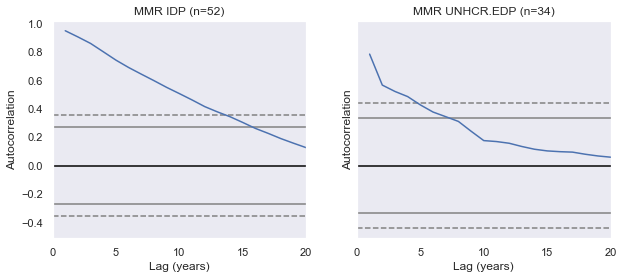

In [6]:
from pandas.plotting import autocorrelation_plot
sns.set(font_scale=1.0)

TARGETS = ['IDP', 'UNHCR.EDP']

for c in countries:
    fig, ax = plt.subplots(1, len(TARGETS), 
                           figsize=(10, 4), 
                           sharex='col', sharey='row')

    for i, t in enumerate(TARGETS):

        idx = df['Country Code'] == c
        tmp = df.loc[idx, ['year', t]]
        tmp = tmp[~tmp[t].isnull()]

        autocorrelation_plot(tmp, ax=ax[i])
        ax[i].set_title("{} {} (n={})".format(c, t, len(tmp)))
        ax[i].set_xlim([0, 20])
        ax[i].set_xlabel('Lag (years)');

    plt.show()
    plt.close()
    
    # plt.savefig("img/autocorrelation-{}.png".format(c), dpi=200, bbox_inches='tight')
    # plt.close()



In [7]:
# Scatter plots (per DRC request)
sns.set(style="white")


for c in countries:
    fig, ax = plt.subplots(1, len(TARGETS), 
                       figsize=(10, 4))
    
    for i, t in enumerate(TARGETS):

        idx = df['Country Code'] == c
        tmp = df.loc[idx, ['year', t]]
        tmp = tmp[~tmp[t].isnull()]

        tmp.sort_values(by='year', inplace=True)
        tmp['T-1'] = tmp[t].shift(1)

        ax[i].scatter(tmp[t], tmp['T-1'])
        ax[i].plot(tmp[t], tmp[t], '-r')
        ax[i].set_aspect('equal', adjustable='box')
        ax[i].set_title("{} {} (n={})".format(c, t, len(tmp)))
        ax[i].set_yticks([], [])
        ax[i].set_ylabel('time $t-1$')
        ax[i].set_xlabel('time $t$');
        
    # plt.show()
    plt.savefig("img/scatter-{}.png".format(c), dpi=200, bbox_inches='tight')
    plt.close()


# Features

In [90]:
def lag_variables(data, var, lag):
    """
    Append lagged variables to frame.
    
    data - pandas data frame
    var - list of variable names to lag
    lag - integer
    
    """
    idx_cols = ['year', 'Country Code']
    fv = var + idx_cols
    
    tmp = data[fv].copy(deep=True)
    
    col_name = [v + ".T" + "{0:+}".format(lag) for v in var]
    
    tmp.rename(columns={k: v for (k, v) in zip(var, col_name)},
               inplace=True)
    tmp.year -= lag
    data = pd.merge(data, tmp, on=idx_cols, how='left')
    
    return data, col_name


def generate_features(data, 
                      training_years,
                      forecast_year,
                      country,
                      target_var,
                      feature_var):
    """ 
    Generate a feature set for training/test
    
    data: pandas Dataframe in long form with all indicator variables
    training_years: Tuple showing min-max years to train on, e.g. (1995, 2010)
    forecast_year: test year, (2011)
    country: ISO3 code (e.g. 'AFG')
    target_var: variable name to forecast e.g. 'FD'
    feature_var: list of variables to include

    returns: 
        Dictionary with training, test data, along with the baseline
        Baseline is the latest flow in the training data.
    """
    
    true_feature_var = [f for f in feature_var]
    print("Total # Features: {}".format(len(true_feature_var)))
    
    dcols = data.columns
    assert target_var in dcols,\
        "Target variable '{}' must be in data frame.".format(target_var)
    
    for fv in feature_var:
        assert fv in dcols,\
            "Feature variable '{}' does not exist.".format(fv)
        
    # Get the poor man's forecast as baseline
    dt = forecast_year - training_years[1]
    bv = data.loc[(data.year == forecast_year - dt) & 
                  (data['Country Code'] == country), target_var].values[0]
    print("Baseline value: {} (year {})".format(bv, forecast_year - dt))
    
    # Get the true value
    tr = data.loc[(data.year == forecast_year) & 
                  (data['Country Code'] == country), target_var].values[0]
    print("True value: {} (year {})".format(tr, forecast_year))
    
    # Target variable offset by a year (y_(t+dt))
    data, varname = lag_variables(data, [target_var], dt)
    true_target_var = varname[0]
    
    # Temporal filter: since the target variable is lagged, the training
    # year is one year prior.
    yl, yu = training_years
    t1 = data.year.between(*(yl, yu - dt))
    v1 = data.year == forecast_year - dt 
    
    # Spatial filter
    t2 = data['Country Code'] == country
        
    # For an AR(1) we just include current year value
    #true_feature_var += [target_var]

    # Handle the missing features
    data = data.fillna(method='ffill').fillna(method='bfill')
    
    # Training data
    Xt = data.loc[t1 & t2, true_feature_var]
    yt = data.loc[t1 & t2, true_target_var]
    
    # Forecast/validation data
    Xv = data.loc[v1 & t2, true_feature_var]
    yv = data.loc[v1 & t2, true_target_var]
    
    # Drop missing training labels
    idx = ~pd.isnull(yt)
    yt = yt[idx]
    Xt = Xt[idx]
    
    return {'data': (Xt, yt, Xv, yv), 'baseline': bv, 'true': tr, 'Country code': c}

In [9]:
# Forecast variable is the total of both internal and external displacement
df['TARGET'] = df['IDP'] + df['UNHCR.EDP']

# Models

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Variables to predict
TARGETS = ['TARGET']

# Years to predict the variables for (all one-year ahead for now)
lag = 1
PERIODS = [{'train_years': (1995, Y - lag), 
            'predict_year': Y } for Y in np.arange(2010, 2016, 1)]

# Models to evaluate
MODELS = [('XGBoost-0.1', Pipeline([("Preprocessor", SimpleImputer(strategy='mean')),
                                ("Estimator", GradientBoostingRegressor(n_estimators=500, 
                                                                 max_depth=6, 
                                                                 learning_rate=0.1, 
                                                                 loss='ls'))])),
          ('XGBoost-0.001', Pipeline([("Preprocessor", SimpleImputer(strategy='mean')),
                                ("Estimator", GradientBoostingRegressor(n_estimators=500, 
                                                                 max_depth=6, 
                                                                 learning_rate=0.001, 
                                                                 loss='ls'))])),
          ("Linear Regression", linear_model.LinearRegression()),
          ("Support Vector Regression", SVR(gamma='auto'))]



In [92]:
results = []
batch = 0
start_time = time()

for c in countries:
    for p in PERIODS:

        batch += 1

        # Generate problem instance
        d = generate_features(df, 
                  p['train_years'],
                  p['predict_year'],
                c,
                  "TARGET",
                  features)

        Xt, yt, Xv, yv = d['data']

        for lbl, clf in MODELS:

            M = {}
            M['batch'] = batch
            M['period'] = p
            M['target'] = "FORCED_DISPLACEMENT" 
            M['baseline'] = d['baseline']
            M['true'] = yv.values[0]
            M['country'] = c
            
            # And finally run 
            M['model'] = lbl

            clf.fit(Xt, yt)
            fc = clf.predict(Xv)
            M['forecast'] = fc[0]
            
            # MAE
            M['mae'] = metrics.mean_absolute_error(yv, fc)

            results.append(M)


with open("result.pkl", 'wb') as outfile:
    pickle.dump(results, outfile)
    
print("Done with {} runs in in {:3.2f} sec.".format(len(results), time() - start_time))

Total # Features: 103
Baseline value: 3216014.0 (year 2009)
True value: 3444902.0 (year 2010)
Total # Features: 103
Baseline value: 3444902.0 (year 2010)
True value: 3155003.0 (year 2011)
Total # Features: 103
Baseline value: 3155003.0 (year 2011)
True value: 3141557.0 (year 2012)
Total # Features: 103
Baseline value: 3141557.0 (year 2012)
True value: 3263128.0 (year 2013)
Total # Features: 103
Baseline value: 3263128.0 (year 2013)
True value: 3493729.0 (year 2014)
Total # Features: 103
Baseline value: 3493729.0 (year 2014)
True value: 4099246.0 (year 2015)
Total # Features: 103
Baseline value: 899259.0 (year 2009)
True value: 883940.0 (year 2010)
Total # Features: 103
Baseline value: 883940.0 (year 2010)
True value: 888738.0 (year 2011)
Total # Features: 103
Baseline value: 888738.0 (year 2011)
True value: 891004.0 (year 2012)
Total # Features: 103
Baseline value: 891004.0 (year 2012)
True value: 1165796.0 (year 2013)
Total # Features: 103
Baseline value: 1165796.0 (year 2013)
True va

In [93]:
import numpy as np

with open("result.pkl", 'rb') as outfile:
    print("Using cached results.")
    results = pickle.load(outfile)
    
df_acc = pd.DataFrame(results)

def mape(t, y): return np.mean(np.abs((t - y) / t))
    
def quality(x):
    
    y_pred = x.forecast
    y_true = x.true
    y_baseline = x.baseline
    
    return pd.Series({'mape-pred': mape(y_true, y_pred),
            'mape-baseline': mape(y_true, y_baseline)})

groups = df_acc.groupby(['country', 'model']).apply(quality)

(groups
 .style
 .set_properties(**{'text-align': 'right'})
 .format({"mape-{}".format(c): "{:.1%}" for c in ['pred', 'baseline']}))

Using cached results.
